What's been done here?

1. Get unique list of genes from HIPPIE(after removing 0 PPIs)
2. Shortlist GTEX with those unique genes (check for duplicates & remove)
3. Create GTEX attributes - gene level and gene-tissue level

End product - Looks like below - Available at /scratch1/gowthami/GTF/GTF_Project_v2/data/gene_tissue_parameter_df.p

Things that need to be fixed before using this data

1. There are Nan values in some of the attributes, have to remove them
2. There is space in tissue name - have to fix it when mapping this to diseases and later with HPA.

In [18]:
gt_exp_param_df.head(5)

,Gene,Tissue,MeanExp,SDofExp,ZScore,MedianExp,Breadth,CoeffOfVar,MedAbsDev
0,ENSG00000187634,Stomach,4.720096,4.267317,-0.036851,3.423000,0.763231,0.904074,2.489289
1,ENSG00000188976,Stomach,44.847466,15.854806,-0.412520,42.380001,0.220056,0.353527,14.366420
2,ENSG00000187961,Stomach,11.037735,4.394696,-0.145059,10.360000,0.445682,0.398152,3.558246
3,ENSG00000187583,Stomach,1.643722,1.750657,-0.314139,1.138000,0.682451,1.065057,1.040194
4,ENSG00000187642,Stomach,0.612194,0.432204,-0.298348,0.489900,0.454039,0.705991,0.274874


In [1]:
import pandas as pd
import csv
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,10
import matplotlib.mlab as mlab
from IPython.display import display
pd.options.display.max_columns = None
from numpy import random
from scipy import stats
import collections
from statsmodels import robust
import datetime
import itertools


# Now calculating the gene level parameters across the tissues

In [2]:
print(datetime.datetime.now().time())
gtex_shortlisted  = pd.read_csv(
    '/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/gtex_shortlisted.tsv',
    sep='\t',chunksize=100)



00:51:25.584738


In [3]:
gene_list = []
mean_list = []
median_list = []
std_list = []

count = 0
print(count, datetime.datetime.now().time())
for chunk in gtex_shortlisted:
    count+=1
    genes = chunk['Name'].tolist()
    genes = [i.split('.')[0] for i in genes] 
    expressions_np = np.array(chunk.iloc[:,2:]).astype(np.float32)
    means = np.mean(expressions_np, axis=1)
    medians = np.median(expressions_np, axis=1)
    stds = np.std(expressions_np, axis=1)
    gene_list.append(genes)
    mean_list.append(means)
    median_list.append(medians)
    std_list.append(stds)
    if count%10 ==0:
        print(count, datetime.datetime.now().time())
        
gene_mean_dict = dict(zip(list(itertools.chain(*gene_list)), list(itertools.chain(*mean_list)))) 
gene_median_dict = dict(zip(list(itertools.chain(*gene_list)), list(itertools.chain(*median_list)))) 
gene_std_dict = dict(zip(list(itertools.chain(*gene_list)), list(itertools.chain(*std_list)))) 

pickle.dump( gene_mean_dict, 
            open( "/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/gene_mean_dict.p", "wb" ) )
pickle.dump( gene_median_dict, 
            open( "/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/gene_median_dict.p", "wb" ) )
pickle.dump( gene_std_dict, 
            open( "/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/gene_std_dict.p", "wb" ) )
        

0 00:51:27.537049
10 00:52:54.489488
20 00:54:20.364857
30 00:55:46.205589
40 00:57:12.196077
50 00:58:38.434237
60 01:00:04.351167
70 01:01:30.413644
80 01:02:56.437582
90 01:04:22.359916
100 01:05:48.294401
110 01:07:13.975118
120 01:08:39.963472
130 01:10:05.757115
140 01:11:31.709314
150 01:12:57.556575
160 01:14:23.691215


NameError: name 'gene_mean_dict_all' is not defined

# Now mapping sampleids to their relevant tissues.
Following steps are followed - 

1. Read the file which is mapping ids to tissues
2. Convert the gtex data into long format.
3. Map the ids to relevant tissues
4. Convert it into a dict for faster access when it's passed on the function later!


In [5]:
temp = gtex_shortlisted  = pd.read_csv(
    '/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/gtex_shortlisted.tsv',
    sep='\t',nrows = 2)
col_list = temp.columns.tolist()[2:]
print(len(col_list))

sampleid_mapping = pd.read_csv('/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/'+
                               'data_generated/GTEx_Tissue_Attributes.csv',
                               sep='\t')
sampleid_mapping = sampleid_mapping[sampleid_mapping['SAMPID'].isin(col_list)]
print(sampleid_mapping.shape)
sampleid_mapping.head(2)


17382
(17382, 3)


,SAMPID,SMTS,SMTSD
5,GTEX-1117F-0226-SM-5GZZ7,Adipose Tissue,Adipose - Subcutaneous
6,GTEX-1117F-0426-SM-5EGHI,Muscle,Muscle - Skeletal


In [6]:
tissues = set(sampleid_mapping['SMTS'].tolist())
tissue_sample_map = {key: [] for key in tissues}
for index, row in sampleid_mapping.iterrows():
    tissue_sample_map[row['SMTS']].append(row['SAMPID'])

In [7]:
print(datetime.datetime.now().time())
gtex_shortlisted  = pd.read_csv(
    '/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/gtex_shortlisted.tsv',
    sep='\t',chunksize=100)

count = 0
print(count, datetime.datetime.now().time())
g_t_exp_dict = {}
for chunk in gtex_shortlisted:
    count+=1
    genes = chunk['Name'].tolist()
    genes = [i.split('.')[0] for i in genes]
    for tissue in tissues:
        cols = tissue_sample_map[tissue]     
        gt = [i+'_'+tissue for i in genes]
        expressions_np = np.array(chunk[cols]).astype(np.float32)
        temp_dict = dict(zip(gt,expressions_np))
        g_t_exp_dict.update(temp_dict)
        
    if count%5 ==0:
        print(count, datetime.datetime.now().time())
        
pickle.dump( g_t_exp_dict, 
            open( "/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/g_t_exp_dict.p", "wb" ) )

01:19:22.569291
0 01:19:22.585231
5 01:20:05.587458
10 01:20:48.569513
15 01:21:31.421124
20 01:22:14.244095
25 01:22:57.152216
30 01:23:40.003349
35 01:24:22.896252
40 01:25:05.715481
45 01:25:48.496967
50 01:26:31.444908
55 01:27:14.273871
60 01:27:57.098039
65 01:28:40.015401
70 01:29:22.982489
75 01:30:05.956296
80 01:30:48.909912
85 01:31:31.737324
90 01:32:14.697227
95 01:32:57.623488
100 01:33:40.594158
105 01:34:23.460434
110 01:35:06.325638
115 01:35:49.281140
120 01:36:32.284870
125 01:37:15.093616
130 01:37:57.899579
135 01:38:40.844039
140 01:39:23.698984
160 01:42:14.889789
165 01:42:58.319541


In [8]:
def breadth_calc(data,thresh,key):
    data = np.array(data)
    try:
        ratio = np.sum(np.array(data>=thresh,dtype=int))/len(data)
        return ratio
    except:
        print('breadth broke at '+ key)
        return 0

def gene_tissue_level_attributes(gt_exp_dict,m_dict,med_dict,sd_dict):
    
    gene_list = []
    tissue_list = []
    mean_val = []
    std_dev = []
    median_val = []
    cv = []
    mad = []
    breadth = []
    zscore = []
    gts = gt_exp_dict.keys()
    print("Total rows: "+str(len(gts)))
    count = 0
    print(count, datetime.datetime.now().time())
    
    for key in gts:
        count+=1
        [gene,tissue] = key.split('_')
        data = gt_exp_dict[key]
        #print(data)
        gene_list.append(gene)
        tissue_list.append(tissue)
        gt_mean = np.mean(data)
        mean_val.append(gt_mean)
        std_dev.append(np.std(data))
        median_val.append(np.median(data))
        cv.append(np.std(data)/ np.mean(data))
        mad.append(robust.mad(data))
        
        
        #getting data from gene df here
        gene_mean = m_dict[gene]
        gene_sd = sd_dict[gene]
        threshold_breadth = med_dict[gene]
        ##done 
        
        breadth.append(breadth_calc(data,threshold_breadth,key))
        zscore.append(float((gt_mean-gene_mean)/gene_sd))
        if count%10000 == 0:
            print(count, datetime.datetime.now().time())
            
            
    d = { 'Gene': gene_list, 'Tissue':tissue_list,
         'MeanExp' : mean_val, 'SDofExp' : std_dev, 'ZScore':zscore,
          'MedianExp':median_val,
         'Breadth': breadth,'CoeffOfVar': cv, 'MedAbsDev':mad
        }
    
    gene_tissue_parameter_df = pd.DataFrame(d)
    
    return gene_tissue_parameter_df
                

In [9]:
gt_exp_param_df = gene_tissue_level_attributes(g_t_exp_dict,
                                                        gene_mean_dict,gene_median_dict,gene_std_dict)
pickle.dump( gt_exp_param_df, 
            open( "/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/gt_exp_param_df.p", "wb" ) )

Total rows: 498600
0 01:43:36.744111
10000 01:43:45.529950
20000 01:43:54.352228
30000 01:44:03.119744


/fs/cbcb-scratch/gowthami/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in float_scalars


40000 01:44:11.876642
50000 01:44:20.640664
60000 01:44:29.366320
70000 01:44:38.108608
80000 01:44:46.884318
90000 01:44:55.608977


/fs/cbcb-scratch/gowthami/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in float_scalars


100000 01:45:04.364465
110000 01:45:13.129857
120000 01:45:21.850224
130000 01:45:30.586274
140000 01:45:39.362195
150000 01:45:48.070731
160000 01:45:56.813283
170000 01:46:05.554836
180000 01:46:14.260951
190000 01:46:23.010833
200000 01:46:31.773315
210000 01:46:40.498819
220000 01:46:49.261031
230000 01:46:58.016888
240000 01:47:06.747632
250000 01:47:15.487279
260000 01:47:24.248605
270000 01:47:32.960378
280000 01:47:41.717547
290000 01:47:50.456380
300000 01:47:59.165451
310000 01:48:07.893160
320000 01:48:16.665973
330000 01:48:25.377094
340000 01:48:34.139458
350000 01:48:42.906983
360000 01:48:51.620334
370000 01:49:00.366092
380000 01:49:09.131233
390000 01:49:17.809682
400000 01:49:26.555255
410000 01:49:35.297539
420000 01:49:43.999914
430000 01:49:52.748098
440000 01:50:01.486421
450000 01:50:10.189155
460000 01:50:18.918267
470000 01:50:27.665551
480000 01:50:36.368601
490000 01:50:45.074910


In [10]:
print(gt_exp_param_df.shape)
gt_exp_param_df.head()

(498600, 9)


,Gene,Tissue,MeanExp,SDofExp,ZScore,MedianExp,Breadth,CoeffOfVar,MedAbsDev
0,ENSG00000187634,Stomach,4.720096,4.267317,-0.036851,3.423000,0.763231,0.904074,2.489289
1,ENSG00000188976,Stomach,44.847466,15.854806,-0.412520,42.380001,0.220056,0.353527,14.366420
2,ENSG00000187961,Stomach,11.037735,4.394696,-0.145059,10.360000,0.445682,0.398152,3.558246
3,ENSG00000187583,Stomach,1.643722,1.750657,-0.314139,1.138000,0.682451,1.065057,1.040194
4,ENSG00000187642,Stomach,0.612194,0.432204,-0.298348,0.489900,0.454039,0.705991,0.274874


In [11]:
gt_exp_param_df.isna().any()

Gene          False
Tissue        False
MeanExp       False
SDofExp       False
ZScore         True
MedianExp     False
Breadth       False
CoeffOfVar     True
MedAbsDev     False
dtype: bool

In [12]:
gt_exp_param_df[gt_exp_param_df.isna().any(axis=1)]

,Gene,Tissue,MeanExp,SDofExp,ZScore,MedianExp,Breadth,CoeffOfVar,MedAbsDev
32133,ENSG00000185962,Fallopian Tube,0.0,0.0,-0.072563,0.0,1.0,NaN,0.0
32136,ENSG00000187170,Fallopian Tube,0.0,0.0,-0.218608,0.0,1.0,NaN,0.0
35189,ENSG00000196184,Fallopian Tube,0.0,0.0,-0.126608,0.0,1.0,NaN,0.0
38165,ENSG00000162763,Fallopian Tube,0.0,0.0,-0.142651,0.0,1.0,NaN,0.0
45334,ENSG00000284485,Testis,0.0,0.0,-0.150718,0.0,1.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...
498574,ENSG00000182415,Kidney,0.0,0.0,-0.109439,0.0,1.0,NaN,0.0
498582,ENSG00000183753,Kidney,0.0,0.0,-0.036980,0.0,1.0,NaN,0.0
498583,ENSG00000188120,Kidney,0.0,0.0,-0.091776,0.0,1.0,NaN,0.0
498585,ENSG00000205916,Kidney,0.0,0.0,-0.093716,0.0,1.0,NaN,0.0


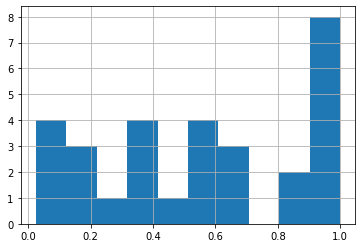

In [13]:
gt_exp_param_df[gt_exp_param_df['Gene'] == 'ENSG00000188976']['Breadth'].hist()

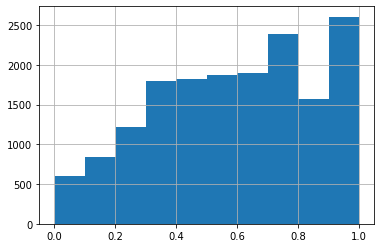

In [17]:
gt_exp_param_df[gt_exp_param_df['Tissue'] == 'Skin']['Breadth'].hist()

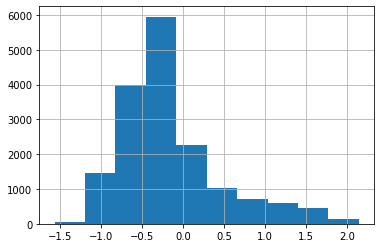

In [15]:
gt_exp_param_df[gt_exp_param_df['Tissue'] == 'Brain']['ZScore'].hist()

# Creating a lookup dict

In [6]:
gtex_shortlisted  = pd.read_csv(
    '/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/gtex_shortlisted.tsv',
    sep='\t',chunksize=100)
ensembl_list = []
genename_list = []
count = 0
print(count, datetime.datetime.now().time())
for chunk in gtex_shortlisted:
    count+=1
    el = chunk['Name'].tolist()
    el = [i.split('.')[0] for i in el] 
    gnl = chunk['Description'].tolist()
    ensembl_list = ensembl_list+ el
    genename_list = genename_list + gnl
    if count%10 ==0:
        print(count, datetime.datetime.now().time())
        

ens2gname_lookup = dict(zip(ensembl_list,genename_list))
gname2ens_lookup = dict(zip(genename_list,ensembl_list))

pickle.dump( ens2gname_lookup, 
            open( "/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/ens2gname_lookup.p", "wb" ) )
pickle.dump( gname2ens_lookup, 
            open( "/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data_generated/gname2ens_lookup.p", "wb" ) )


0 13:17:14.191280
10 13:18:40.512294
20 13:20:06.736758
30 13:21:33.020446
40 13:22:59.180221
50 13:24:27.213690
60 13:25:53.390433
70 13:27:19.624906
80 13:28:45.755513
90 13:30:11.957442
100 13:31:38.199514
110 13:33:04.627329
120 13:34:32.145681
130 13:35:58.269262
140 13:37:24.073363
150 13:38:50.340326
160 13:40:16.371827
